In [1]:
import glob
import pandas as pd
from zedstat import zedstat
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def _process_roc(questions, files, base_fpr=np.linspace(0, 1, 101)):
    from scipy.spatial import ConvexHull
    from scipy.interpolate import interp1d

    tprs = []

    for i, df in enumerate(files):
        tpr = pd.read_csv(df).query("questions==@questions")["tpr"]
        fpr = pd.read_csv(df).query("questions==@questions")["fpr"]
        fpr_i = fpr.drop_duplicates(keep="last")
        tpr_i = tpr.loc[fpr_i.index.values]
        # interp = interp1d(fpr_i, tpr_i, kind="quadratic")
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    rf = pd.DataFrame(
        {
            "mean": mean_tprs,
            "lower": tprs_lower,
            "upper": tprs_upper,
            "base_fpr": base_fpr,
        }
    ).clip(lower=0, upper=1)

    def __convex_hull(fprcol="base_fpr", tprcol="mean"):
        pts = rf[[fprcol, tprcol]].values
        hull = ConvexHull(pts)
        rf_ = pd.DataFrame(pts[hull.vertices, 0], pts[hull.vertices, 1]).reset_index()
        rf_.columns = [tprcol, fprcol]
        rf_ = rf_.set_index(fprcol)

        rf_ = rf_.drop(1.0).sort_index()
        rf_.loc[1.0] = 1.0

        return rf_.reset_index()

    rfm = __convex_hull()
    rfl = __convex_hull(tprcol="lower")
    rfu = __convex_hull(tprcol="upper")

    pd.merge(pd.merge(rfm, rfl, on="base_fpr"), rfu, on="base_fpr")

    return rf

In [8]:
_process_roc(36, files=glob.glob("rf_auc_res/roc_df_rf_2023-07-23 2*")).to_csv(
    "roc36.csv", index=False
)

In [38]:
rdf = _process_roc(26, files=glob.glob("rf_auc_res/roc_df_rf_2023-07-23 2*"))

plt.plot(rdf["base_fpr"], rdf["mean"], "b")
plt.fill_between(rdf["base_fpr"], rdf["lower"], rdf["upper"], color="grey", alpha=0.3)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

ValueError: Expect x to not have duplicates

In [27]:
DF

,mean,lower,upper,tpr
base_fpr,,,,
0.00,NaN,NaN,NaN,0.0
0.01,0.154346,0.050907,0.257786,NaN
0.01,0.154346,0.050907,0.257786,NaN
0.02,0.155580,0.051811,0.259349,NaN
0.02,0.155580,0.051811,0.259349,NaN
...,...,...,...,...
0.96,0.988494,0.957016,1.000000,NaN
0.97,0.988494,0.957016,1.000000,NaN
0.98,0.988494,0.957016,1.000000,NaN


In [28]:
VAR = "fpr"
STEP = 0.0001
df_ = rdf[["base_fpr", "mean"]].set_axis(["fpr", "tpr"], axis="columns")
DF = pd.concat(
    [
        pd.DataFrame(df_[df_[VAR].between(i, i + STEP)].max()).transpose()
        for i in np.arange(0, 1, STEP)
    ]
).set_index(VAR)
DF = DF.dropna()
DF.loc[0] = pd.Series([], dtype=float)
DF.loc[1] = pd.Series([], dtype=float)
DF.loc[0, "tpr"] = 0
DF.loc[1, "tpr"] = 1

DF = DF.sort_index()
DF = DF.interpolate(limit_direction="both", method="spline", order=3)
DF[DF < 0] = 0
DF

,tpr
fpr,
0.00,0.000000
0.01,0.154346
0.01,0.154346
0.02,0.155580
0.02,0.155580
...,...
0.96,0.988494
0.97,0.988494
0.98,0.988494


<AxesSubplot:xlabel='fpr'>

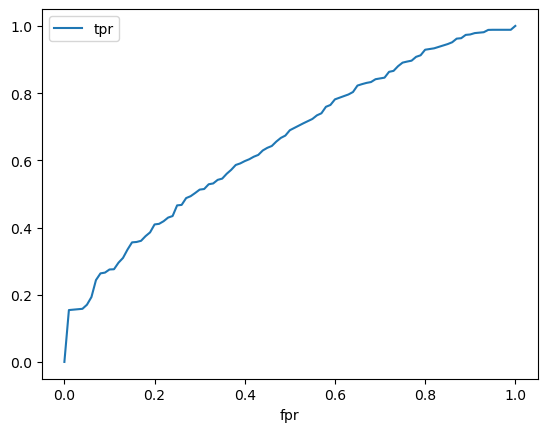

In [29]:
DF.plot()

In [6]:
rf = rdf
fprcol = "base_fpr"
tprcol = "mean"

In [7]:
pts = rf[[fprcol, tprcol]].values

# print(pts)


hull = ConvexHull(pts)
rf_ = pd.DataFrame(pts[hull.vertices, 0], pts[hull.vertices, 1]).reset_index()
rf_.columns = [tprcol, fprcol]
rf_ = rf_.set_index(fprcol)

rf_ = rf_.drop(1.0).sort_index()
rf_.loc[1.0] = 1.0

In [13]:
rf_.reset_index()

,base_fpr,mean
0,0.00,0.000000
1,0.01,0.779803
2,0.08,0.949354
3,0.13,0.981983
4,0.17,0.995658
5,0.19,0.997619
6,0.22,1.000000
7,1.00,1.000000


In [46]:
rdf

,mean,lower,upper,base_fpr
0,0.000000,0.000000,0.000000,0.00
1,0.122072,0.000000,0.253890,0.01
2,0.124976,0.000000,0.257246,0.02
3,0.127880,0.000000,0.261025,0.03
4,0.130784,0.000000,0.265217,0.04
...,...,...,...,...
96,0.984942,0.947791,1.000000,0.96
97,0.985465,0.948915,1.000000,0.97
98,0.985989,0.949942,1.000000,0.98
99,0.986512,0.950867,1.000000,0.99


In [28]:
questions = 31
dfs = [
    pd.read_csv(df).query("questions==@questions")
    for df in glob.glob("rf_auc_res/roc_df_rf_2023-07-23 2*")
]

In [29]:
dfs[0]

,fpr,tpr,threshold,questions
51,0.0,0.000000,1.858458,31
52,0.0,0.047619,0.858458,31
53,0.0,0.142857,0.852724,31
54,0.0,0.190476,0.848965,31
55,0.0,0.285714,0.845862,31
56,0.0,1.000000,0.487505,31
57,1.0,1.000000,0.095273,31


In [35]:
zt = zedstat.processRoc(
    dfs[0],
    order=3,
    total_samples=1000,
    positive_samples=100,
    alpha=0.05,
    prevalence=0.3,
)

zt.smooth(STEP=0.01)
zt.allmeasures(interpolate=False)
zt.usample(precision=3)
zt.getBounds()

zt.auc()

(0.5, 0.5769650289100974, 0.42326878242026134)

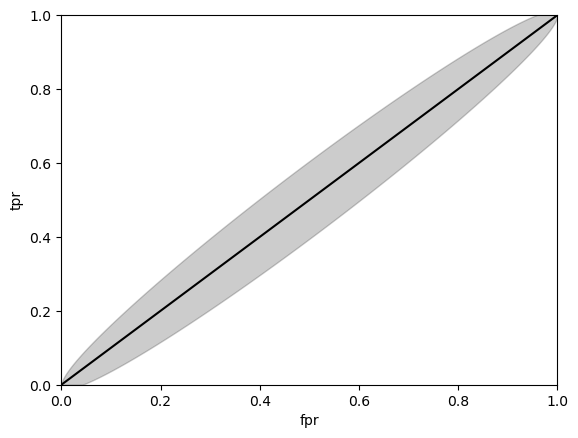

In [31]:
fig, ax = plt.subplots()
ax = zt.get().tpr.plot(ax=ax, color="k")
plt.fill_between(
    x=zt.get().index, y1=zt.df_lim["U"].tpr, y2=zt.df_lim["L"].tpr, color="k", alpha=0.2
)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("tpr")

In [9]:
len(range(1, 102, 5))

21

In [26]:
roc

,fpr,tpr,threshold,questions,curve
51,0.0000,0.000000,1.858458,31,0
52,0.0000,0.047619,0.858458,31,0
53,0.0000,0.142857,0.852724,31,0
54,0.0000,0.190476,0.848965,31,0
55,0.0000,0.285714,0.845862,31,0
...,...,...,...,...,...
62,0.1250,0.941176,0.715739,31,29
63,0.1875,1.000000,0.701711,31,29
64,0.6875,1.000000,0.088492,31,29
65,0.8750,1.000000,0.079944,31,29


In [24]:
roc

,fpr,tpr,threshold,questions
51,0.0000,0.000000,1.858458,31
52,0.0000,0.047619,0.858458,31
53,0.0000,0.142857,0.852724,31
54,0.0000,0.190476,0.848965,31
55,0.0000,0.285714,0.845862,31
...,...,...,...,...
62,0.1250,0.941176,0.715739,31
63,0.1875,1.000000,0.701711,31
64,0.6875,1.000000,0.088492,31
65,0.8750,1.000000,0.079944,31


In [ ]:
tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect("equal", "datalim")

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, "b")
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()